# Multi-armed bandits

##### Imports

In [1]:
import numpy as np
from matplotlib import cycler
from tqdm import tqdm
import copy
import random
from collections import deque
from kilroyplot.plot import plt

##### Utilities

In [2]:
class Bandit:
    """Represents one multi-armed bandit that samples rewards from normal distribution."""
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def reward(self):
        """Sample single reward."""
        return np.random.normal(self.mean, self.std)

In [3]:
from abc import ABC, abstractmethod
    

class Agent:
    """Represents an agent that can estimate action values and pick actions."""
    
    def __init__(self, estimator, picker):
        self.estimator = estimator
        self.picker = picker
        
    def estimate(self):
        """Estimate action values."""
        return self.estimator.estimate()
    
    def pick(self, t):
        """Pick an action."""
        return self.picker.pick(t, self.estimate())
    
    def on_reward(self, action, reward):
        """Reward callback."""
        self.estimator.on_reward(action, reward)
        

class Estimator(ABC):
    """Estimates action values using specific method."""
    
    def __init__(self, n_actions):
        self.n_actions = n_actions
        
    @abstractmethod
    def estimate(self):
        pass
    
    @abstractmethod
    def on_reward(self, action, reward):
        pass
    
    
class WeightedAveragingEstimator(Estimator, ABC):
    """Estimates action values using weighted averaging."""
    
    def __init__(self, n_actions, default=0):
        super().__init__(n_actions)
        self.past_rewards = [{"value": 0, "n_times": 0} for _ in range(n_actions)]
        self.default = default
        
    def estimate(self):
        return [
            rewards["value"] if rewards["n_times"] else self.default 
            for rewards in self.past_rewards
        ]
    
    def on_reward(self, action, reward):
        reward_agg = self.past_rewards[action]
        reward_agg["n_times"] += 1
        reward_agg["value"] += self.step_size(reward_agg["n_times"]) * (reward - reward_agg["value"])
        
    @abstractmethod
    def step_size(self, n):
        pass
    
    
class AveragingEstimator(WeightedAveragingEstimator):
    """Estimates action values using arithmetic mean."""
    
    def step_size(self, n):
        return 1.0 / n
    
    
class ExponentialWeightedAveragingEstimator(WeightedAveragingEstimator):
    """Estimates action values using exponentially-decaying average."""
    
    def __init__(self, n_actions, alpha, default=0):
        super().__init__(n_actions, default)
        self.alpha = alpha
    
    def step_size(self, n):
        return self.alpha
    
    
class Picker(ABC):
    """Picks an action using specific method given action value estimates."""

    def __init__(self, n_actions):
        self.n_actions = n_actions
        
    @abstractmethod
    def pick(self, t, values):
        pass
    
    
class EpsilonGreedyPicker(Picker):
    """Picks the best action or, with epsilon probability, random action."""
    
    def __init__(self, n_actions, epsilon):
        super().__init__(n_actions)
        self.epsilon = epsilon
    
    def pick(self, t, values):
        if random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        maximum = np.max(values)
        argmaxes = np.argwhere(values == maximum).flatten()
        return np.random.choice(argmaxes)

    
class GreedyPicker(EpsilonGreedyPicker):
    """Always picks the best action."""
    
    def __init__(self, n_actions):
        super().__init__(n_actions, 0)
        

class UpperConfidenceBoundPicker(Picker):
    """Picks action using upper-confidence bound."""
    
    def __init__(self, n_actions, c, alpha):
        super().__init__(n_actions)
        self.c = c
        self.alpha = alpha
        self.n_picked = [0] * n_actions
        self.last_picked = [0] * n_actions
        
    def pick(self, t, values):
        values = [
            value + self.c * np.sqrt( np.log( sum(self.n_picked) + 1 ) / ( 1 + self.n_picked[i] ) ) 
            for i, value in enumerate(values)
        ]
        maximum = np.max(values)
        argmaxes = np.argwhere(values == maximum).flatten()
        picked = np.random.choice(argmaxes) 
        self.n_picked[picked] = np.power(self.alpha, t - self.last_picked[picked]) * self.n_picked[picked] + 1
        self.last_picked[picked] = t
        return picked

## Experiments

Runs multiple experiments with $n$ random bandits using all agents. Agents should update their estimates and get better with time.

To make the problem non-stationary, at some step means of each bandit distribution will be mirrored by the mean of the distribution of the bandit that is considered the best at that step.

Average rewards in all experiments at every step are saved to be analyzed later. 

In [4]:
n_bandits = 10

In [5]:
reference_agents = {
    "greedy, average": Agent(AveragingEstimator(n_bandits), GreedyPicker(n_bandits)),
    "eps-greedy, exponential average": Agent(ExponentialWeightedAveragingEstimator(n_bandits, 0.5), EpsilonGreedyPicker(n_bandits, 0.1)),
}

In [6]:
n_problems = 2000
steps = 1000

In [7]:
rewards_agg = {name: [] for name in reference_agents}
for _ in tqdm(range(n_problems)):
    reference_bandits = [Bandit(mean, 1) for mean in np.random.normal(size=n_bandits)]
    agents = {name: copy.deepcopy(agent) for name, agent in reference_agents.items()}
    rewards = {name: [] for name in agents}
    for name, agent in agents.items():
        bandits = copy.deepcopy(reference_bandits)
        for i in range(steps):
            if i == (steps // 4):
                best_bandit = bandits[np.argmax(agent.estimate())]
                bandits = [Bandit(2*best_bandit.mean - bandit.mean, 1) for bandit in bandits]
            bandit = agent.pick(i)
            reward = bandits[bandit].reward()
            agent.on_reward(bandit, reward)
            rewards[name].append(reward)
    for name in agents:
        rewards_agg[name].append(rewards[name])

100%|██████████| 2000/2000 [03:47<00:00,  8.81it/s]


## Results

In [8]:
mean_rewards = {name: np.mean(rewards, axis=0) for name, rewards in rewards_agg.items()}

Text(0, 0.5, 'average reward')

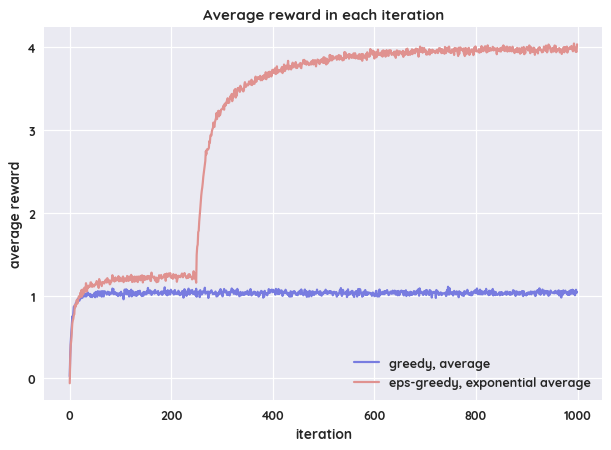

In [9]:
for name, rewards in mean_rewards.items():
    plt.plot(rewards, label=name)
plt.legend()
plt.title("Average reward in each iteration")
plt.xlabel("iteration")
plt.ylabel("average reward")